# 📊 Backtesting Machine Learning Trading Strategies

## Introduction

This notebook explores **backtesting Machine Learning-based trading strategies**, focusing on computationally efficient yet effective approaches, such as **Random Forest**. The goal is to evaluate the performance of these strategies using historical market data.

As with other experiments in this repository, we will leverage **Mini_lib** to facilitate key steps in applying ML to financial data. Specifically, we will:  

1. **Label the data** – Define the target variable for our ML model.  
2. **Generate and analyze features** – Extract meaningful financial indicators.  
3. **Train a model** – Use ML techniques, such as Random Forest, to derive trading signals.  
4. **Implement a strategy** – Convert model predictions into actionable trading rules.  
5. **Backtest the strategy** – Assess its performance using a robust backtesting framework.  

By following this structured approach, we aim to determine the viability of ML-driven trading strategies in real market conditions.

In [1]:
import sys
sys.path.append("../")
import Data as dt
import Mini_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **I. Getting Data and Making Samples**  

The first step in our workflow is to **acquire and preprocess market data**. This involves:  

1. **Fetching historical price data** – Using reliable sources to obtain asset prices.  
2. **Cleaning and preprocessing** – Handling missing values, adjusting for corporate actions, and ensuring consistency.  
   *(Note: The dataset used here is already processed, so we will skip this step.)*  
3. **Creating research samples** – Splitting the data into **Training**, **Testing**, and **Embargo** sets to prevent overfitting.  

### ⚠️ **Important Note**  
A **testing set** should be used **sparingly**! It is recommended to track the number of times it is accessed to prevent data leakage and ensure unbiased model evaluation.  


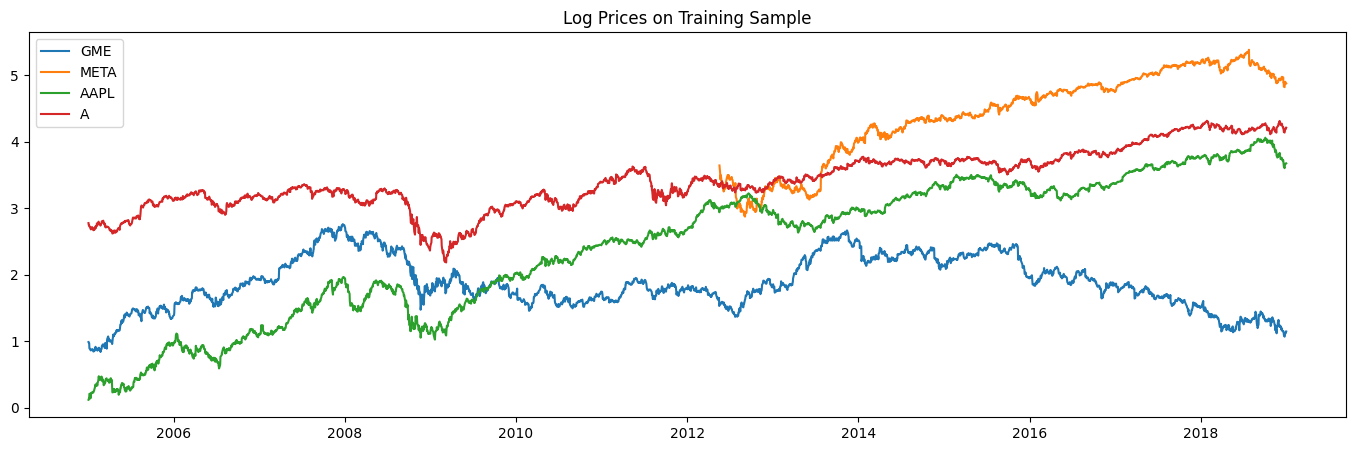

In [ ]:
# I. Load data
data = dt.load_dataList()

# II. Making Samples
training_data = {}
testing_data = {}
embargo_data = {}

for ticker in data.keys():
    full_df = data[ticker]
    training_data[ticker] = full_df.loc['2005-01-01':'2019-01-01']
    testing_data[ticker] = full_df.loc['2019-01-01': '2023-01-01']
    embargo_data[ticker] = full_df.loc['2023-01-01':]

# III. Let's see the training data we have on a log scale
plt.figure(figsize=(17, 5))
for asset_df in training_data.values():
    plt.plot(np.log(asset_df['close']), label=asset_df['code'].iloc[0])
plt.legend()
plt.title('Log Prices on Training Sample')
plt.show()

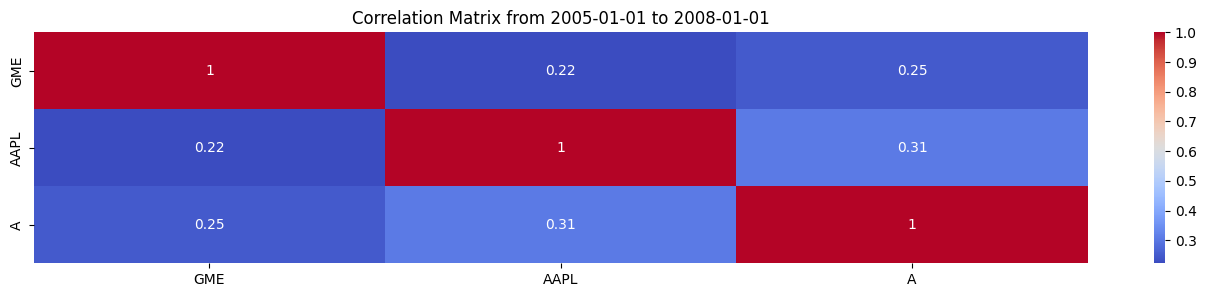

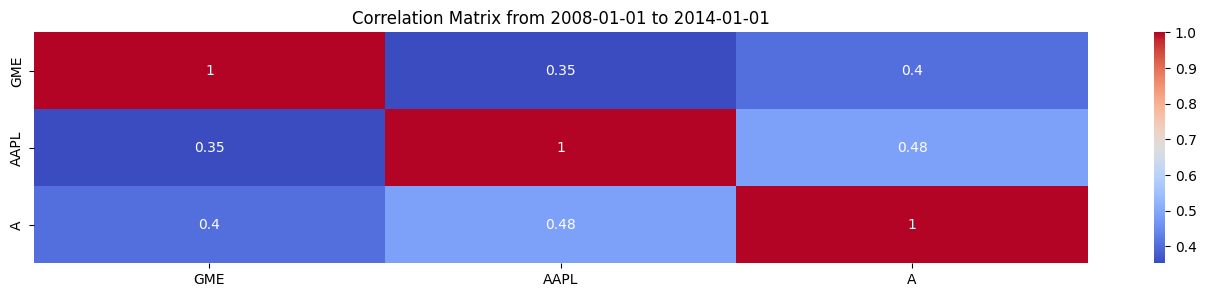

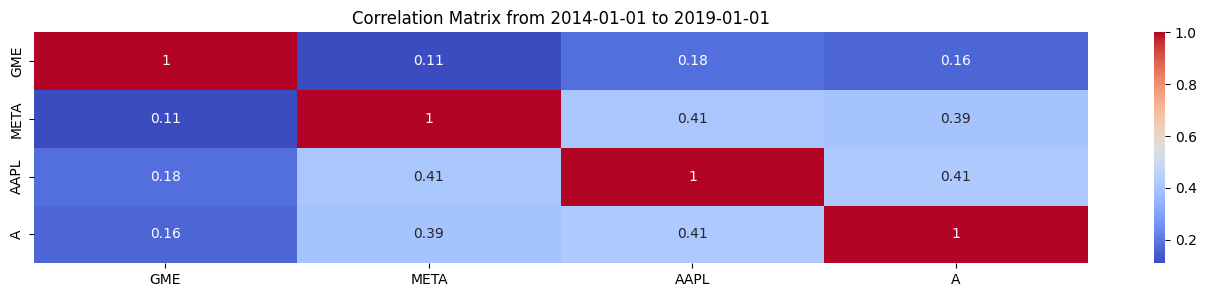

In [25]:
close_df = pd.DataFrame({ticker: asset_df['close'] for ticker, asset_df in training_data.items()})
returns_df = np.log(close_df).diff()
returns_df = returns_df.dropna()

dates_checkpoint = ['2005-01-01', '2008-01-01', '2014-01-01', '2019-01-01']
for idx in range(1, len(dates_checkpoint)):
    date = dates_checkpoint[idx]
    previous_date = dates_checkpoint[idx - 1]

    close_df = pd.DataFrame({ticker: asset_df['close'].loc[previous_date:date] for ticker, asset_df in training_data.items()})
    close_df = close_df.dropna(axis=1)
    returns_df = np.log(close_df).diff()
    returns_df = returns_df.dropna()

    correlation_matrix = returns_df.corr()
    plt.figure(figsize=(17, 3))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix from {previous_date} to {date}')
    plt.show()

### **🔍 Training Set Overview**

Our training dataset consists of **four assets**: `GME`, `META`, `AAPL`, and `A`, spanning from **2005 to 2019**. These assets exhibit distinct price behaviors over time:  

- **AAPL & META** – Consistent strong upward movement.  
- **GME** – Varied performance with shifting market conditions.  
- **A** –  Long term upward movement after a flat period.

One key observation is that **the correlation between these assets changes over time**. This is beneficial for our ML experiment as it provides:  

✅ **Diverse market regimes** – Ensuring the model learns from different conditions.  
✅ **Generalization ability** – Training across different asset behaviors without conflicting signals.  
✅ **Robustness** – Avoiding overfitting to a single asset's characteristics.  

---
## **II. Labelling Data**  

To train our classification models, we need to **define a labeling method** that captures meaningful patterns in price movements.  

### 🎯 **Objective**  
The goal is to assign labels to our dataset that reflect future market conditions, allowing our ML models to learn predictive patterns.  

### 🏷️ **Labeling Approach**  
We apply a **labeling method** to categorize market states based on price behavior. This step is crucial because:  

✅ It transforms raw price data into a structured learning problem.  
✅ It helps the model differentiate between profitable and unprofitable conditions.  
✅ It avoids bias by ensuring well-balanced class distributions.  

In [45]:
# I. Define the plotting function
def plot_price_with_labels(price_series: pd.Series, label_series: pd.Series):

    plt.figure(figsize=(17, 5))
    plt.plot(price_series, label="Prix", color="blue", linewidth=1)

    plt.scatter(price_series.index[label_series == 1], 
                price_series[label_series == 1], 
                color='green', label="Tendance haussière (+1)", marker="^", s=50)
    
    plt.scatter(price_series.index[label_series == -1], 
                price_series[label_series == -1], 
                color='red', label="Tendance baissière (-1)", marker="v", s=50)
    
    plt.scatter(price_series.index[label_series == 0], 
                price_series[label_series == 0], 
                color='gray', label="Neutre (0)", marker="o", s=10, alpha=0.5)

    plt.title(f"Price with Labels {label_series.name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# II. Apply the labellers
tripleBarrier_params = {"upper_barrier": 1, "lower_barrier": 1, "vertical_barrier": 15}
lookForward_params = {"size_window_smooth": 10, "lambda_smooth": 0.2, "trend_size": 5, "volatility_threshold": 1}

for ticker, asset_df in training_data.items():
    close_series = asset_df['close']
    labels_series_tb = lib.tripleBarrier_labeller(price_series=close_series, params=tripleBarrier_params)
    labels_series_lf = lib.lookForward_labeller(price_series=close_series, params=lookForward_params)
    asset_df.loc[:, 'labels_tb'] = labels_series_tb
    asset_df.loc[:, 'labels_lf'] = labels_series_lf

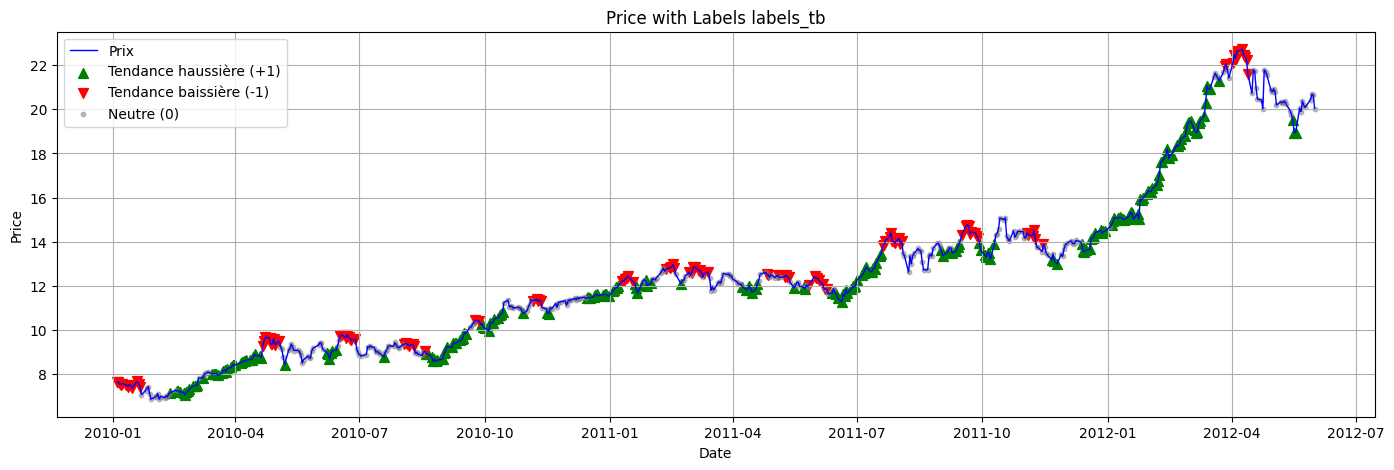

labels_tb
 0.0    261
 1.0    232
-1.0    116
Name: count, dtype: int64


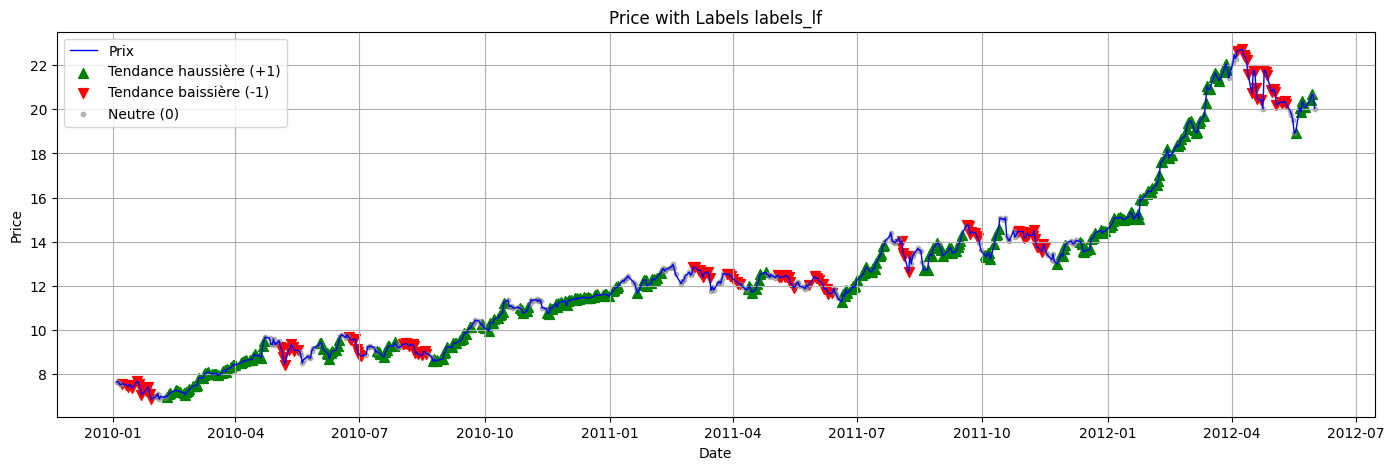

labels_lf
 1    306
 0    166
-1    137
Name: count, dtype: int64


In [ ]:
# III. Plot the some labels to see the difference
price_series = training_data['AAPL']['close'].loc['2010-01-01':'2012-06-01']
labels_tb = training_data['AAPL']['labels_tb'].loc['2010-01-01':'2012-06-01']
labels_lf = training_data['AAPL']['labels_lf'].loc['2010-01-01':'2012-06-01']

plot_price_with_labels(price_series, labels_tb)
print(labels_tb.value_counts())
plot_price_with_labels(price_series, labels_lf)
print(labels_lf.value_counts())

---
## **III. Feature Exploration**  

In this section, we will **generate and analyze features** to determine if they contain meaningful information for our model.  

### 🔍 **Objective**  
The goal is to create financial indicators that help distinguish different market conditions and improve model predictions.  

### ⚙️ **Feature Engineering Process**  
We will:  
1. **Generate features** – Extract technical, statistical, and market-based indicators.  
2. **Analyze their distributions** – Check for patterns and potential predictive power.  
3. **Assess feature importance** – Determine which features contribute the most to classification.  

In [51]:
# I. Create some features
available_windows = [5, 10, 20, 50, 100, 200]
for ticker, asset_df in training_data.items():
    asset_df = asset_df.copy() 
    close_series = asset_df['close']
    for window in available_windows:
        average_feature = lib.average_features(price_series=close_series, window=window)
        quantile_feature = lib.quantile_features(price_series=close_series, window=window, quantile=0.05)
        slope_feature, t_stats_feature, _, _ = lib.linear_tempReg_features(price_series=close_series, regression_window=window)
        hurst_feature, _, _ = lib.hurst_exponent_features(price_series=close_series, power=4)

        asset_df[f'average_{window}'] = average_feature
        asset_df[f'quantile_{window}'] = quantile_feature
        asset_df[f'slope_{window}'] = slope_feature
        asset_df[f't_stats_{window}'] = t_stats_feature
        asset_df[f'hurst_{window}'] = hurst_feature

    training_data[ticker] = asset_df 

In [ ]:
quantile_basic_info = feature_data(quantile)
quantile_descriptive_df = feature_distribution(quantile, feature_name=quantile.name)
feature_plot(quantile, labels_series_tb, feature_name=quantile.name)

In [ ]:


rolling_slope, rolling_tstat, rolling_pvalue, rolling_r_squared = linear_tempReg_features(price_series, 10)
hursts, tstats, pvalues = hurst_exponent_features(price_series, 4)

In [ ]:
slope_basic_info = feature_data(rolling_slope)
slope_descriptive_df = feature_distribution(rolling_slope, feature_name=rolling_slope.name)
feature_plot(rolling_slope, labels_series_tb, feature_name=rolling_slope.name)

In [ ]:
hurst_basic_info = feature_data(hursts)
hurst_descriptive_df = feature_distribution(hursts, feature_name=hursts.name)
feature_plot(hursts, labels_series_tb, feature_name=hursts.name)

In [ ]:
features_df = pd.DataFrame({
    'label': labels_series_lf,
    "average": average,
    "quantile": quantile,
    "rolling_slope": rolling_slope,
    "hurst": hursts,
})

features_correlation(features_df)